# Automated Email Marketing Part #2: Connecting Klaviyo to LangChain

Klaviyo is a marketing automation platform that integrates with 300+ data sources across your entire tech stack and stores all your customer data together. This allows you to send hyper-personalized, targeted messages all while efficiently automating your workflow across marketing channels. The platform has several features for marketers including segmentation tools, content templates, and easy analytics. In this project we will leverage these tools through the Klaviyo API integrating a dynamic LangChain prompting sequence to generate highly personalized and effective emails to these sample customers. Credit for this idea goes to @rabbitmetrics on youtube. Let's see how this works.

### Shopify Development Store

We begin by creating a Shopify development store going to  add stores and create development store. Here's what my store looked like: 

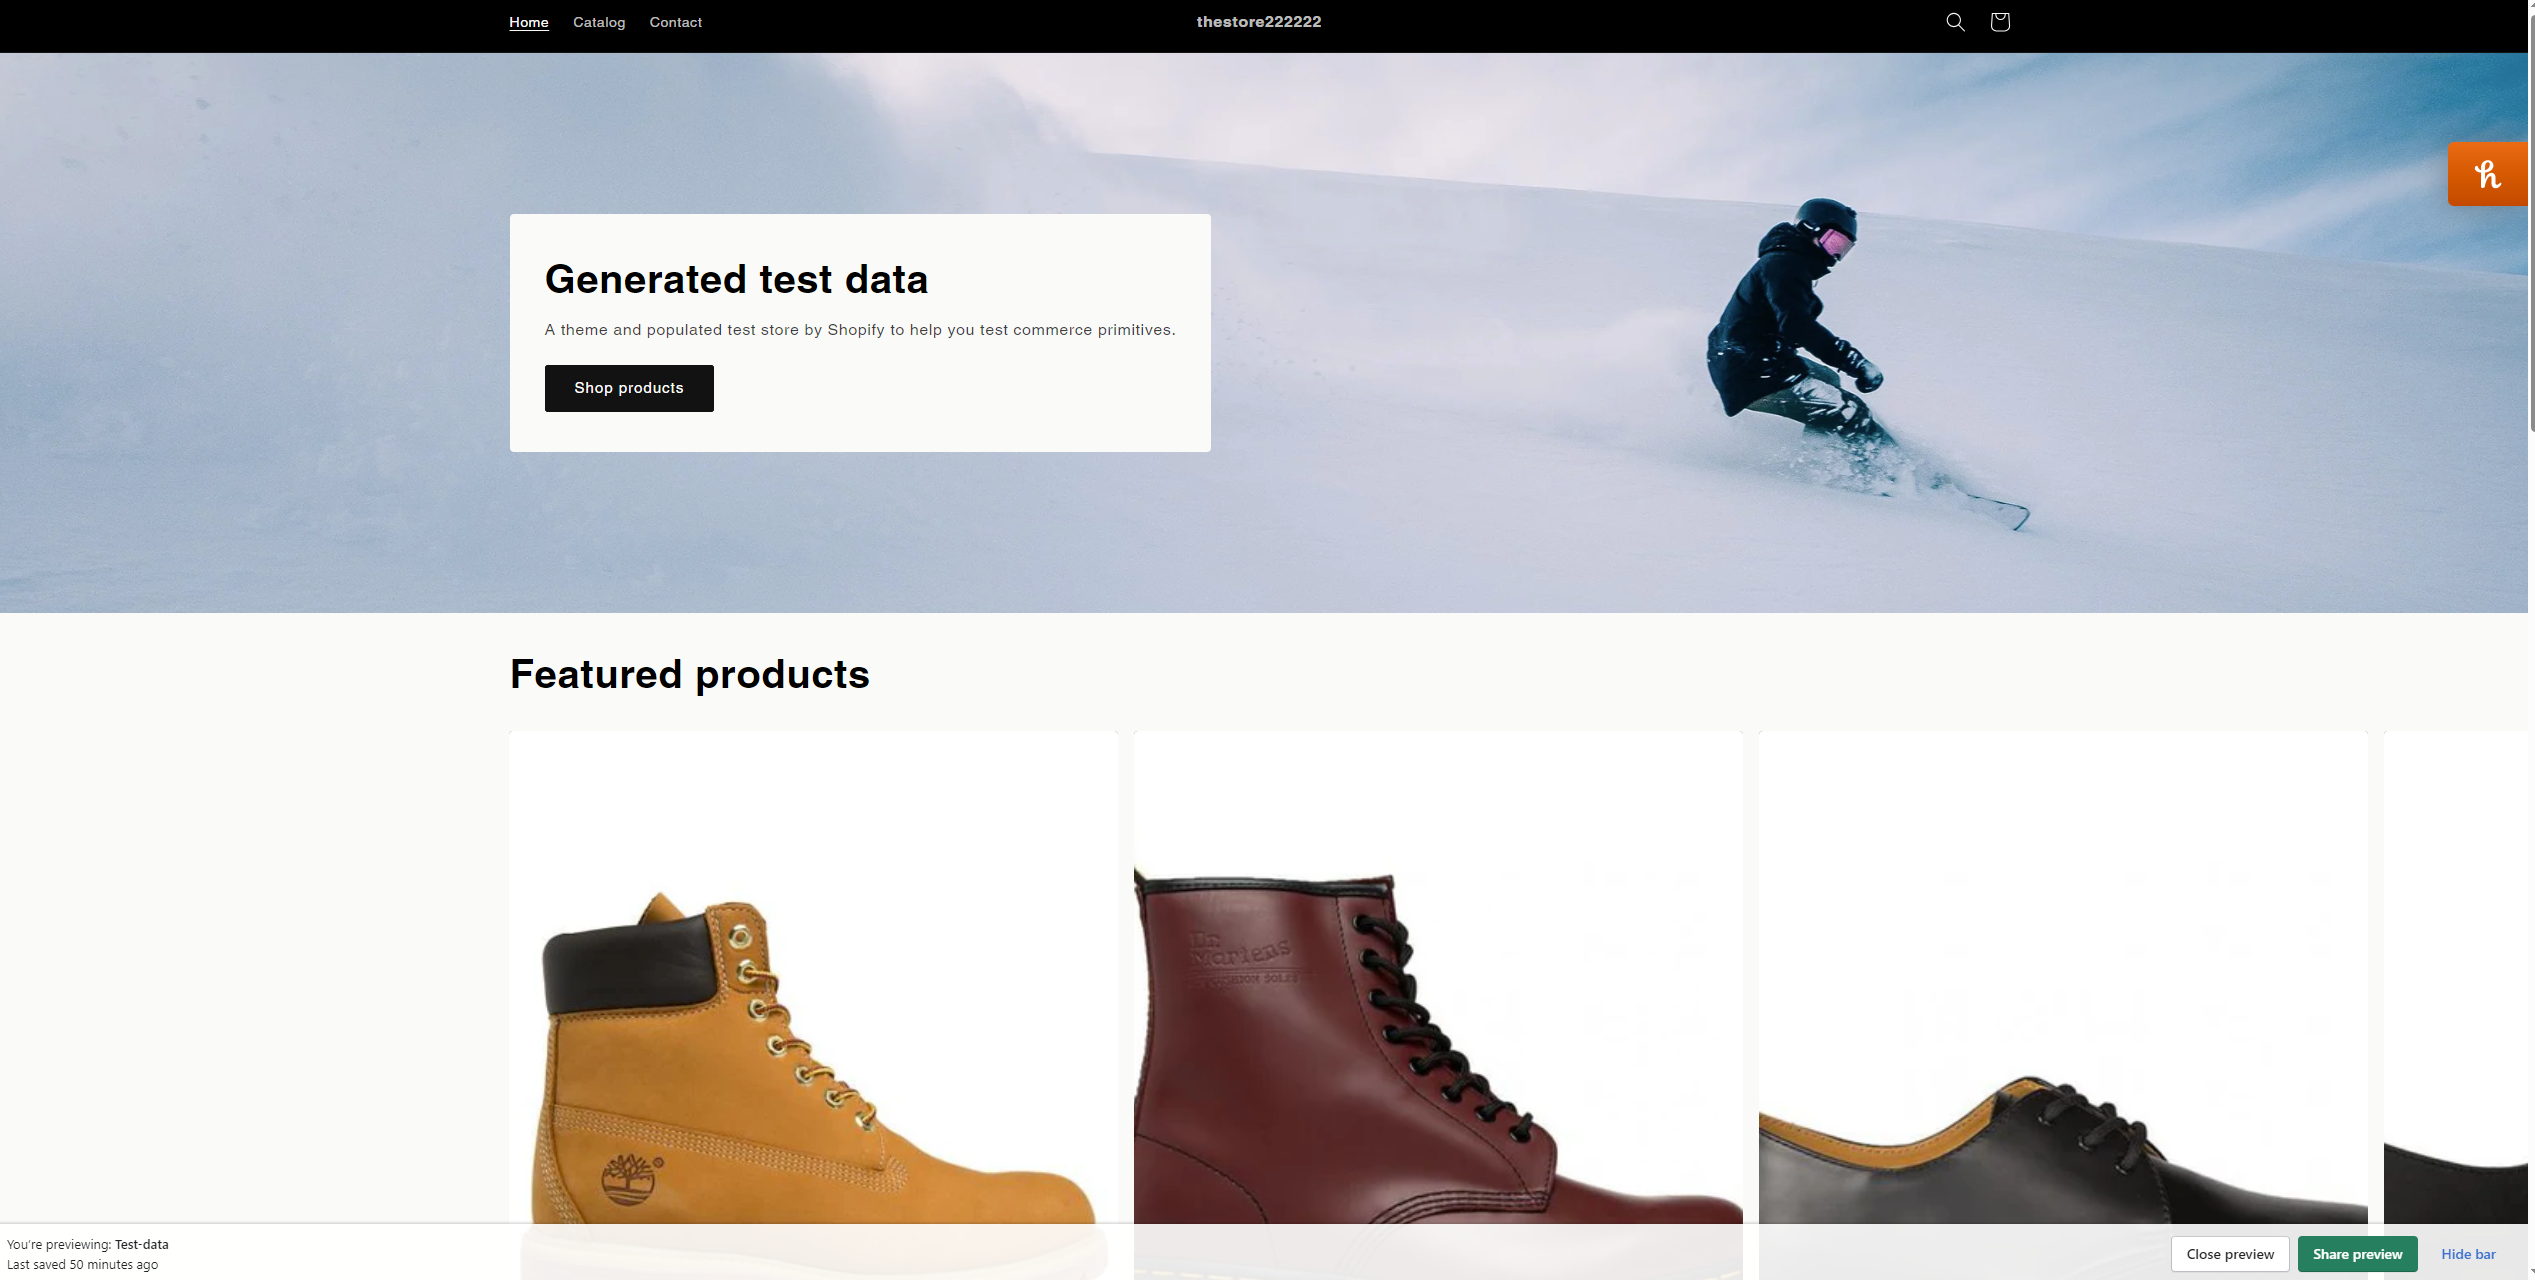

### Connecting Klaviyo Dummy Customers

We then went to the test store and install the Klaviyo and Simple Sample Data apps. After going through the setups we create ten sample customers using the Simple Sample Data app:

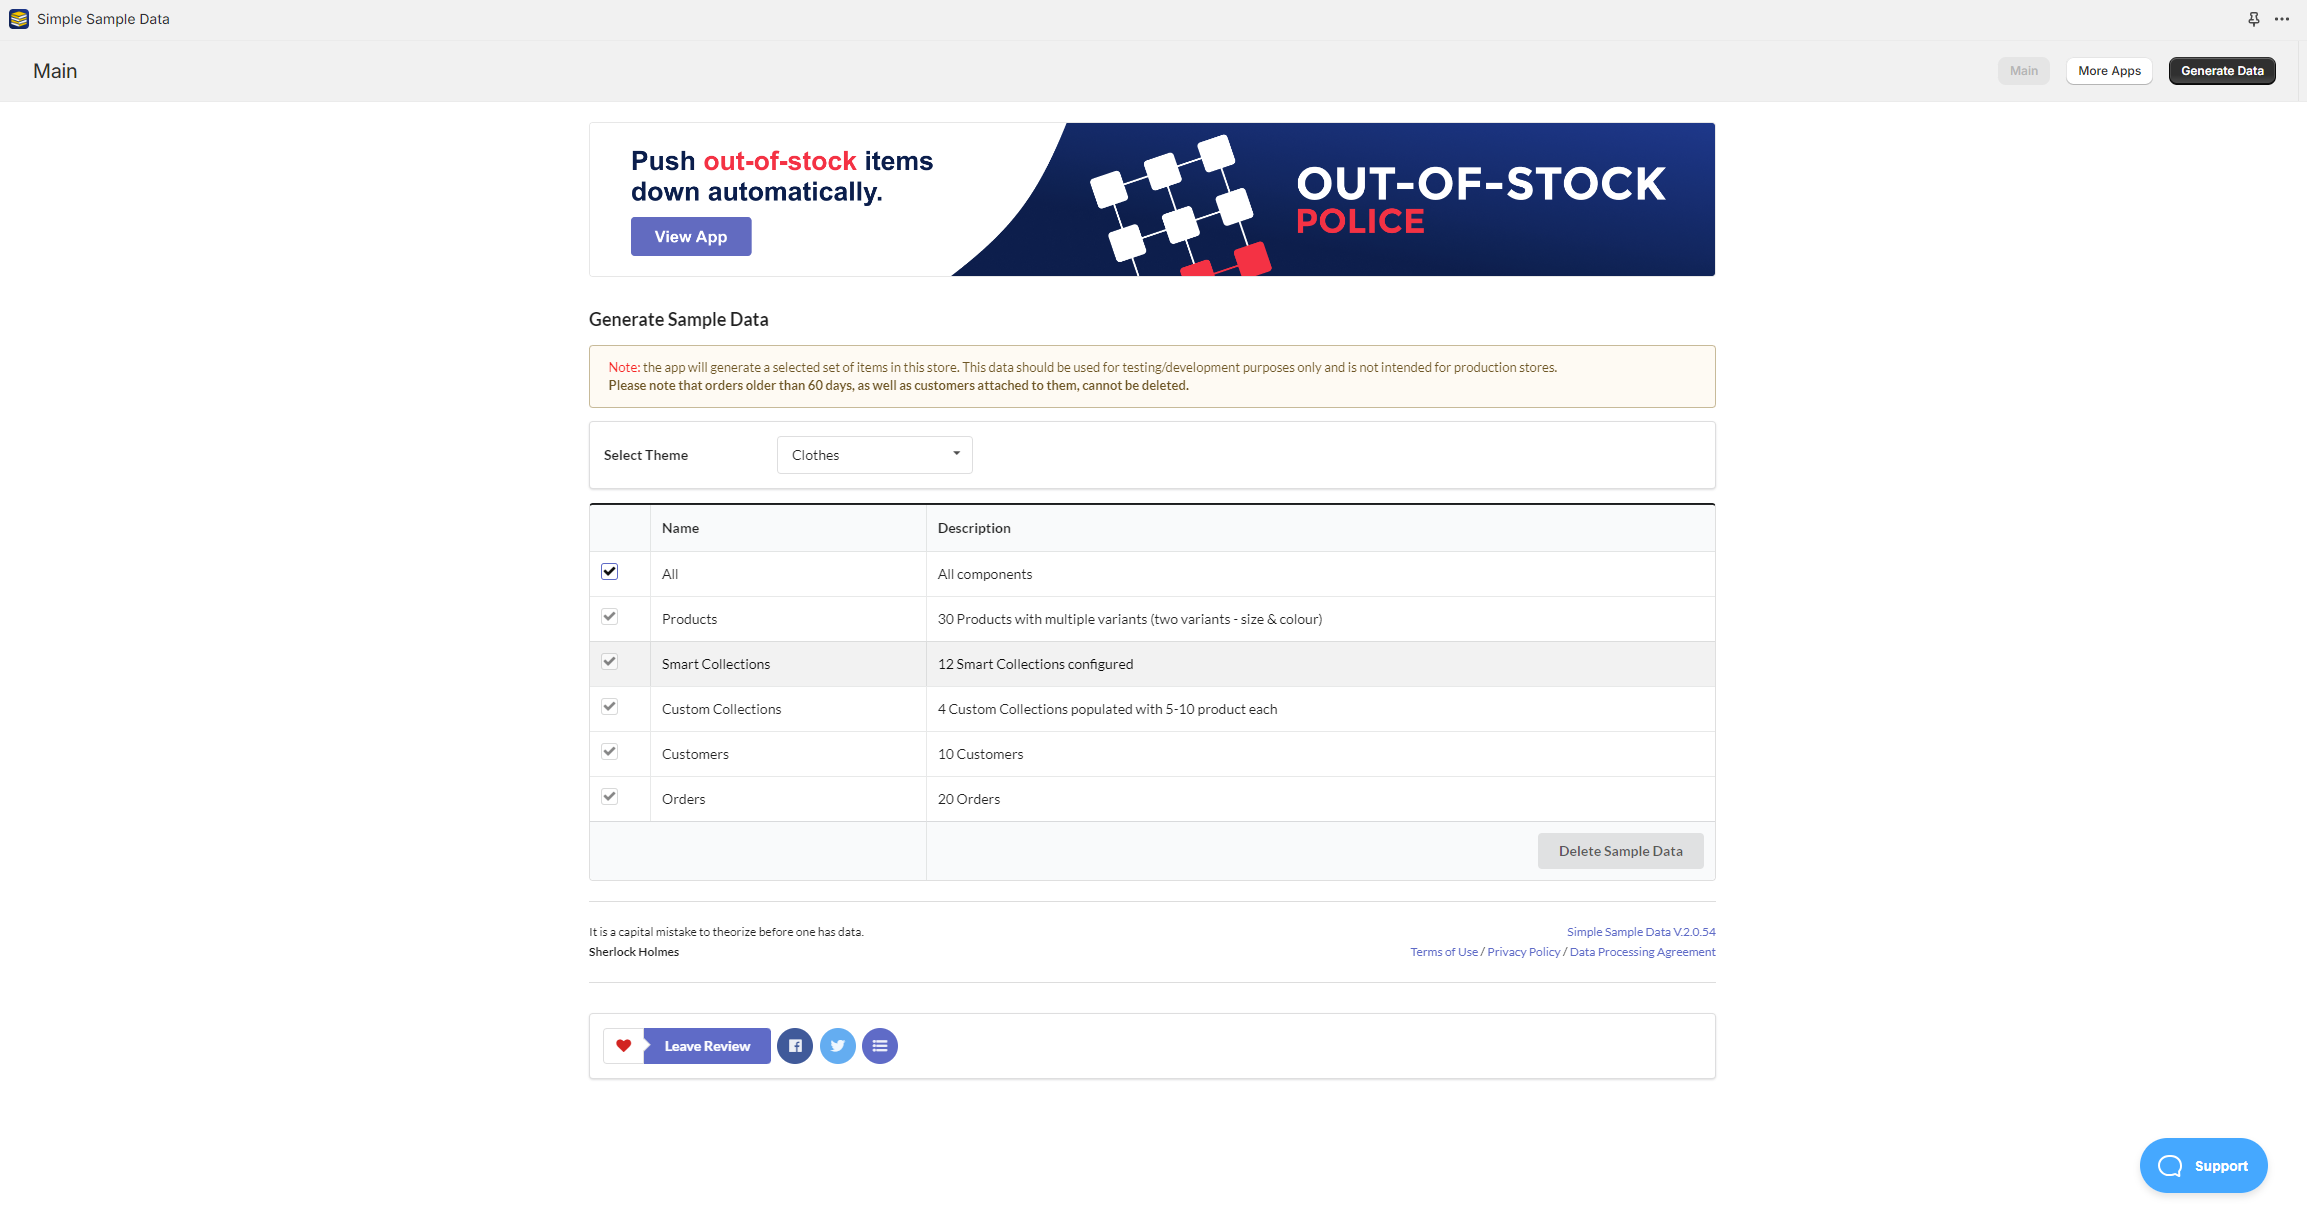

### Connecting to Klaviyo API

Finally, we can install Klaviyo and connect to our sample customer data.

In [1]:
import os
from dotenv import load_dotenv
from klaviyo_api import KlaviyoAPI

from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

_ = load_dotenv()

In [2]:
# Extract Klaviyo (private) API key from .env file
klaviyo_key=...

In [3]:
# Instantiate the Klaviyo Python API with the API key

klaviyo = KlaviyoAPI(klaviyo_key, max_delay=60, max_retries=3, test_host=None)

In [4]:
# Extract a sample of Metrics from the Klaviyo API

klaviyo.Metrics.get_metrics()

{'data': [{'type': 'metric',
   'id': 'R8A4y9',
   'attributes': {'name': 'Subscribed to SMS Marketing',
    'created': '2024-04-15T00:48:21+00:00',
    'updated': '2024-04-15T00:48:21+00:00',
    'integration': {'object': 'integration',
     'id': '0rG4eQ',
     'key': 'klaviyo',
     'name': 'Klaviyo',
     'category': 'Internal'}},
   'links': {'self': 'https://a.klaviyo.com/api/metrics/R8A4y9/'}},
  {'type': 'metric',
   'id': 'RKB7aL',
   'attributes': {'name': 'Received SMS',
    'created': '2024-04-15T00:48:21+00:00',
    'updated': '2024-04-15T00:48:21+00:00',
    'integration': {'object': 'integration',
     'id': '0rG4eQ',
     'key': 'klaviyo',
     'name': 'Klaviyo',
     'category': 'Internal'}},
   'links': {'self': 'https://a.klaviyo.com/api/metrics/RKB7aL/'}},
  {'type': 'metric',
   'id': 'RQemwa',
   'attributes': {'name': 'Clicked email to unsubscribe',
    'created': '2024-04-15T00:48:17+00:00',
    'updated': '2024-04-15T00:48:17+00:00',
    'integration': {'object

In [5]:
# Store a sample customer ID from Klaviyo in an object

karine_ruby="01HVFKKSPHKNC5PV0VNN14TSJ4"

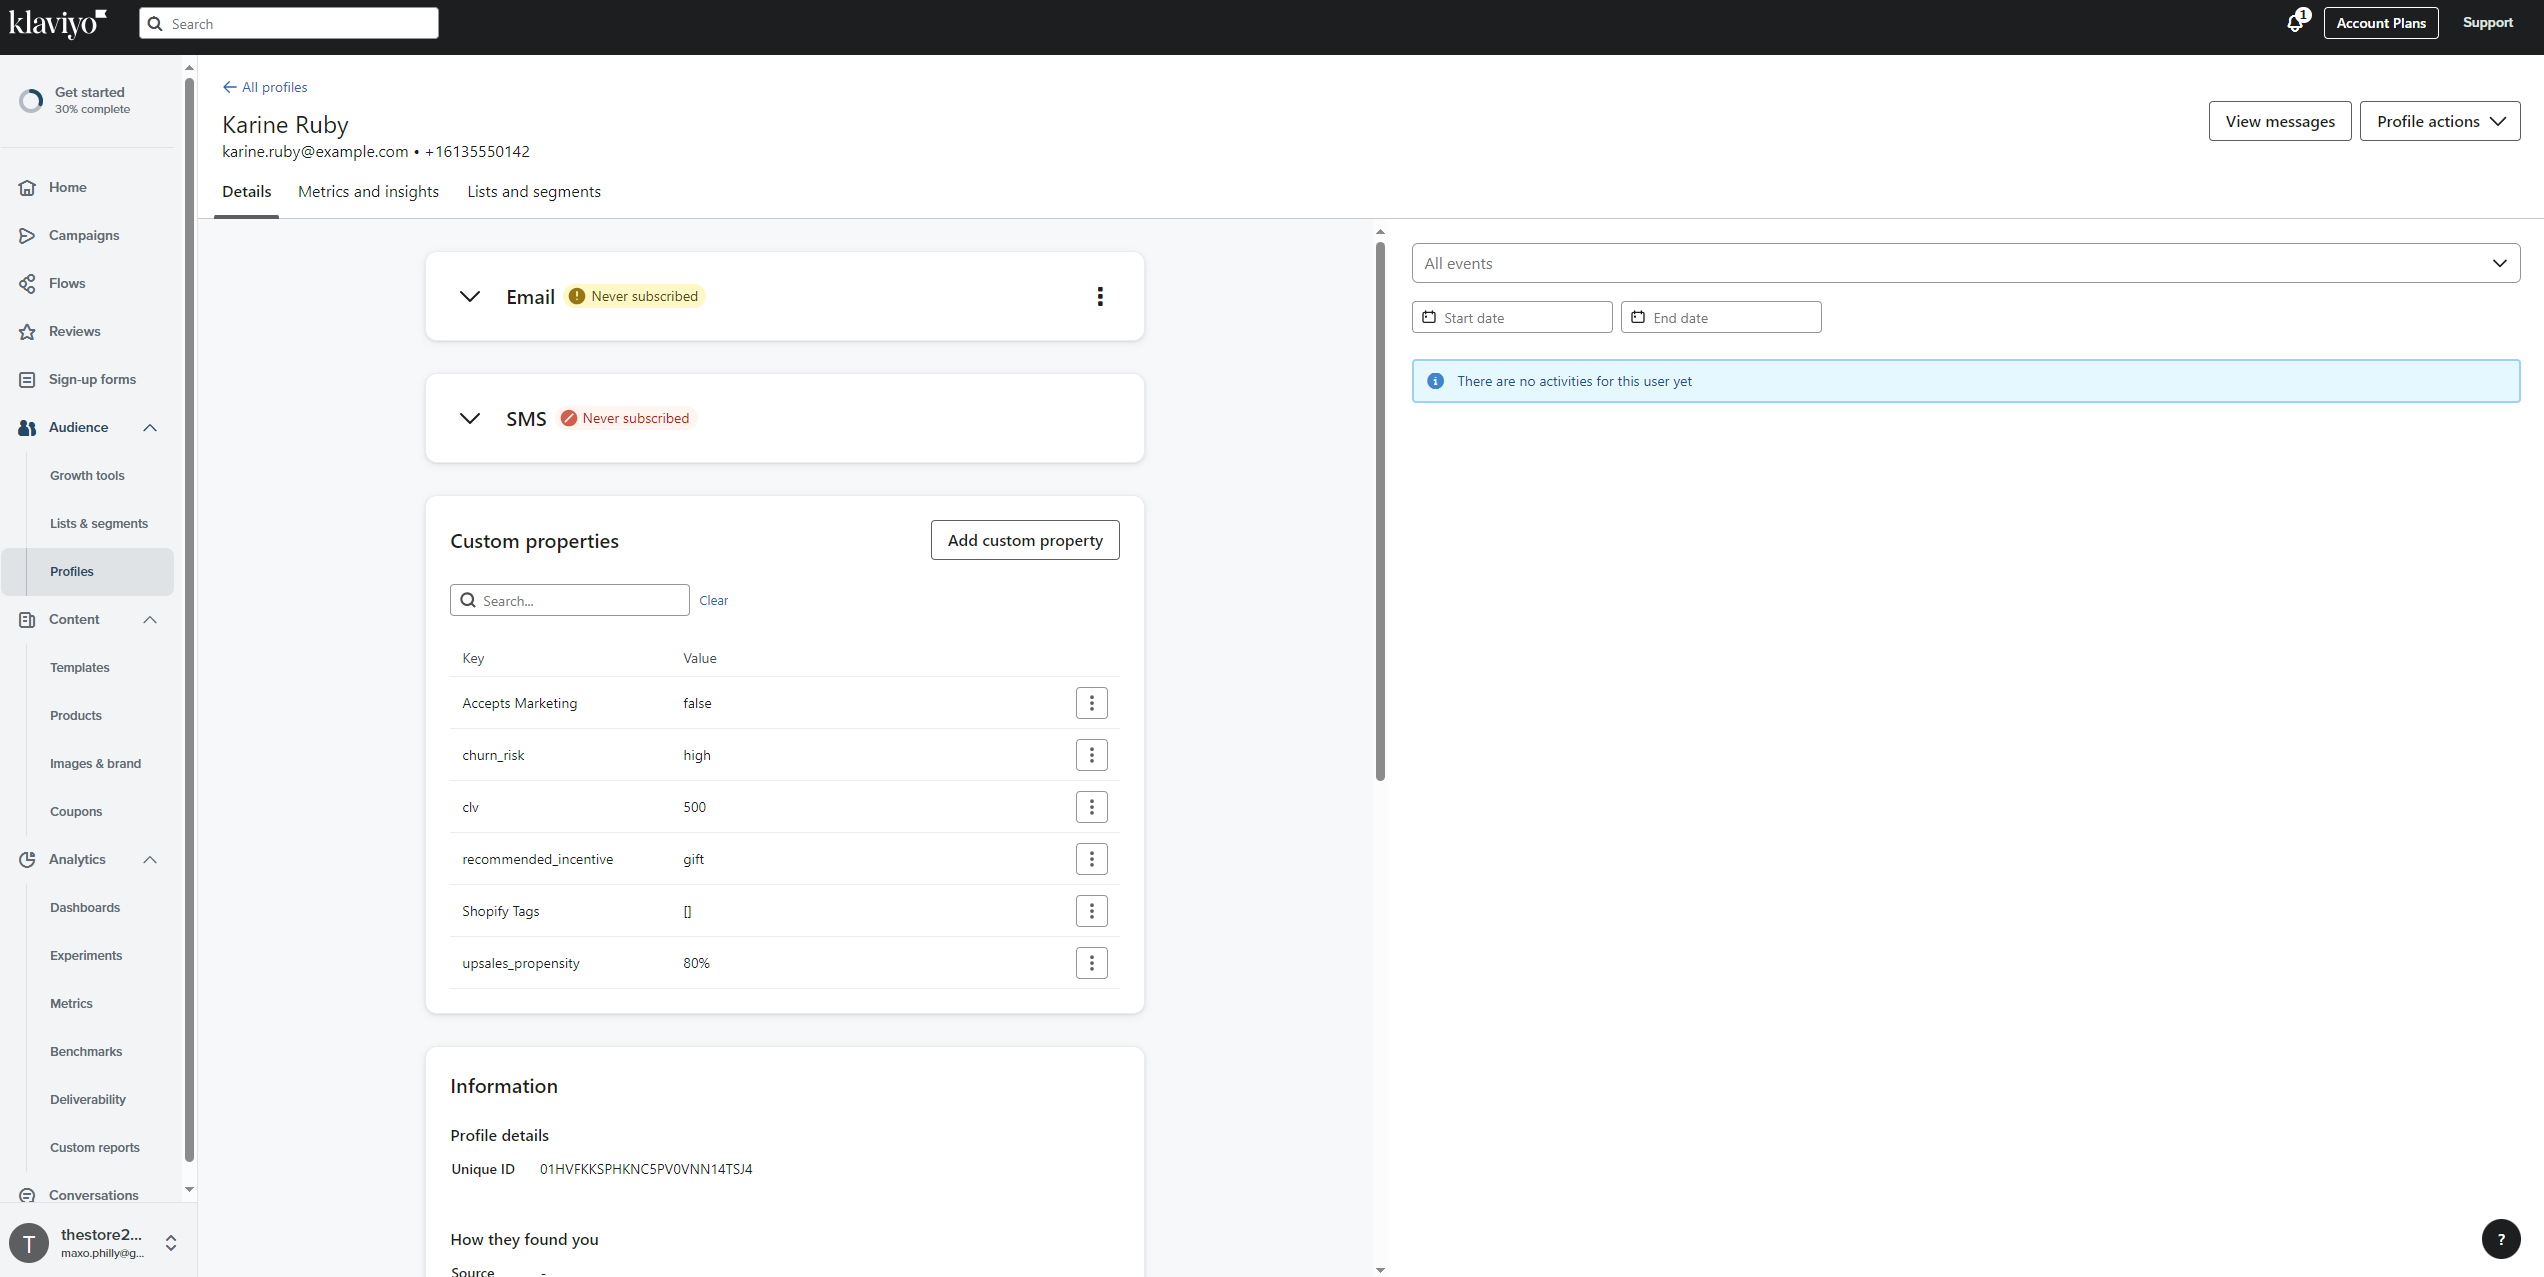

In [6]:
# Get a single profile based on the Klaviyo ID

profile=klaviyo.Profiles.get_profile(
    karine_ruby
)
print(profile)

{'data': {'type': 'profile', 'id': '01HVFKKSPHKNC5PV0VNN14TSJ4', 'attributes': {'email': 'karine.ruby@example.com', 'phone_number': '+16135550142', 'external_id': None, 'anonymous_id': None, 'first_name': 'Karine', 'last_name': 'Ruby', 'organization': None, 'title': None, 'image': None, 'created': '2024-04-15T00:48:18+00:00', 'updated': '2024-04-21T21:42:21+00:00', 'last_event_date': '2024-04-21T21:41:50+00:00', 'location': {'country': None, 'region': None, 'address2': None, 'address1': None, 'latitude': None, 'zip': None, 'longitude': None, 'city': None, 'timezone': None, 'ip': None}, 'properties': {'Accepts Marketing': True, 'Shopify Tags': [], 'clv': 500, 'churn_risk': 'high', 'upsales_propensity': '80%', 'recommended_incentive': 'gift', '$consent': ['email'], '$source': -6, '$consent_timestamp': '2024-04-21T21:41:48.951Z'}}, 'relationships': {'lists': {'links': {'self': 'https://a.klaviyo.com/api/profiles/01HVFKKSPHKNC5PV0VNN14TSJ4/relationships/lists/', 'related': 'https://a.klavi

In [7]:
# From here we can update a profile with custom properties

payload={ "data": {
        "type": "profile",
        "id": karine_ruby,
        "attributes": {
            'properties':{
                'clv':500,
                'churn_risk':'high',
                'upsales_propensity': '80%',
                'recommended_incentive': 'gift'
            }
                    }
            }
     }

klaviyo.Profiles.update_profile(karine_ruby, payload)

{'data': {'type': 'profile',
  'id': '01HVFKKSPHKNC5PV0VNN14TSJ4',
  'attributes': {'email': 'karine.ruby@example.com',
   'phone_number': '+16135550142',
   'external_id': None,
   'anonymous_id': None,
   'first_name': 'Karine',
   'last_name': 'Ruby',
   'organization': None,
   'title': None,
   'image': None,
   'created': '2024-04-15T00:48:18+00:00',
   'updated': '2024-04-21T21:42:21+00:00',
   'last_event_date': '2024-04-21T21:41:50+00:00',
   'location': {'address2': None,
    'city': None,
    'zip': None,
    'country': None,
    'region': None,
    'latitude': None,
    'address1': None,
    'longitude': None,
    'timezone': None,
    'ip': None},
   'properties': {'Accepts Marketing': True,
    'Shopify Tags': [],
    'clv': 500,
    'churn_risk': 'high',
    'upsales_propensity': '80%',
    'recommended_incentive': 'gift',
    '$consent': ['email'],
    '$source': -6,
    '$consent_timestamp': '2024-04-21T21:41:48.951Z'}},
  'relationships': {'lists': {'links': {'self': 

In [8]:
# Extract profile data and events for a Klaviyo ID as a string we can feed to LangChain

def get_customer_data(custid):
    profile=klaviyo.Profiles.get_profile(custid)
    data = profile['data']
    attributes = data['attributes']
    properties = attributes['properties']
    location = attributes['location']
    info = {key: value for key, value in attributes.items() if key not in ['properties', 'location']}
    combined_dict = {**properties, **location, **info}
    return combined_dict

In [9]:
data=get_customer_data(karine_ruby)
data

{'Accepts Marketing': True,
 'Shopify Tags': [],
 'clv': 500,
 'churn_risk': 'high',
 'upsales_propensity': '80%',
 'recommended_incentive': 'gift',
 '$consent': ['email'],
 '$source': -6,
 '$consent_timestamp': '2024-04-21T21:41:48.951Z',
 'region': None,
 'zip': None,
 'address1': None,
 'city': None,
 'address2': None,
 'longitude': None,
 'country': None,
 'latitude': None,
 'timezone': None,
 'ip': None,
 'email': 'karine.ruby@example.com',
 'phone_number': '+16135550142',
 'external_id': None,
 'anonymous_id': None,
 'first_name': 'Karine',
 'last_name': 'Ruby',
 'organization': None,
 'title': None,
 'image': None,
 'created': '2024-04-15T00:48:18+00:00',
 'updated': '2024-04-21T21:42:21+00:00',
 'last_event_date': '2024-04-21T21:41:50+00:00'}

In [10]:
# Simple LLM chain that allows us to produce personalized text based on data from Klaviyo

prompt_template = """
Write a short 2 line introduction to an email with a hook from Max's Store to a customer with these
Don't mention the properties or the property values but try to use the properties {upsales_propensity} and {recommended_incentive} in the formulation.
Remember not to mention these properties explicitly, but craft your message to resonate with these insights.
Address it to {first_name}.
"""

llm = ChatOpenAI(model_name="gpt-4", temperature=0.2)
llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)
intro=llm_chain(data)

print(intro['text'])

/usr/local/anaconda3/share/jupyter/venv/py311_4130_v2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/anaconda3/share/jupyter/venv/py311_4130_v2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Subject: Unwrap a Surprise Just for You, Karine!

Dear Karine, imagine saving more while getting an extra treat with your next purchase from Max's Store!


Notice how model has built the unique customer information into its response. Still, this hook is weirdly technical and kind of creepy. In the next post we'll look at the fun part. Trying to get the an LLM to sell.